In [ ]:
# Helpful packages for working with images and factorizations
#using Pkg; Pkg.add("Images")
#using Pkg; Pkg.add("ImageMagick") # And this allows us to load JPEG-encoded images
using Images, LinearAlgebra, ImageMagick

### Using a SVD to compress an image

In this exercise, we'll use a singular value decomposition (SVD) to compress an image -- so that we can store an image without keeping around "unnecessary" information.

To start, let's define a singular value decomposition. In a SVD, we take a matrix $A$ and factorize it so that

$$A = USV^T$$

where matrices $U$ and $V$ are unitary and hold our singular vectors. Matrix $S$ is diagonal and stores our singular values in decreasing order from top/left to bottom/right.

In Julia, our images are stored as arrays, so we can think of `shield` as a matrix

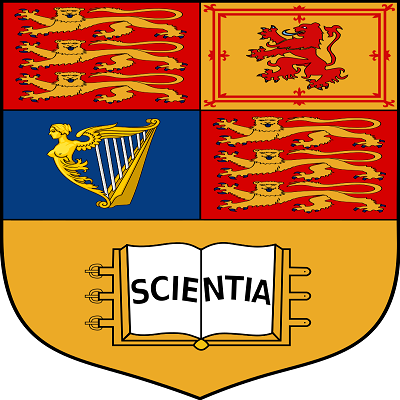

In [2]:
shield = load("../assets/Shield_of_Imperial_College_London.png")

In [3]:
size(shield)

(400, 400)

In [4]:
shield[100,50] # Each element in the array is a color

That means we can take the SVD of this image. So, we can store this picture of a shield as sets of singular vectors and singular values.

**The reason this is important** is that we'll find that we do **not** need to keep track of *all* the singular vectors and *all* the singular values to store an image that still looks like a shield! This means we can choose to keep only the important information, throw away the rest, and thereby "compress" the image.

Working with grayscale images is a bit easier, so let's work with the gray version of this shield.

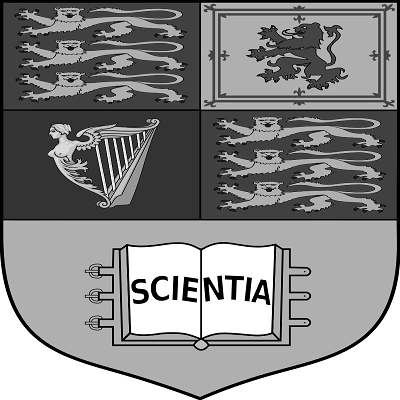

In [5]:
gshield = Gray.(shield)

Note that `gshield` is a (400,400) matrix that stores a pixel -- information about the color -- at each entry.

In [7]:
size(gshield)

(400, 400)

In [8]:
gshield[100, 50]

If we take the `channelview` of `gshield`, we'll see the numbers that describe the color at each point in the array:

In [9]:
channelview(gshield)

400×400 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.0  0.0  0.0  0.0    0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0    0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.043  0.063  0.059     0.161  0.165  0.161  0.0  0.0  0.0
 0.0  0.0  0.0  0.192  0.282  0.271     0.745  0.749  0.71   0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251     0.686  0.694  0.659  0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251  …  0.686  0.694  0.663  0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251     0.686  0.694  0.663  0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251     0.714  0.694  0.663  0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251     0.439  0.725  0.663  0.0  0.0  0.0
 0.0  0.0  0.0  0.176  0.259  0.251     0.239  0.698  0.667  0.0  0.0  0.0
 ⋮                            ⋮      ⋱         ⋮                       
 1.0  1.0  1.0  1.0    1.0    1.0       1.0    1.0    1.0    1.0  1.0  1.0
 1.0  1.0  1.0  1.0    1.0 

Note that you can call `Gray` on the `channelview` of an image to display the image!

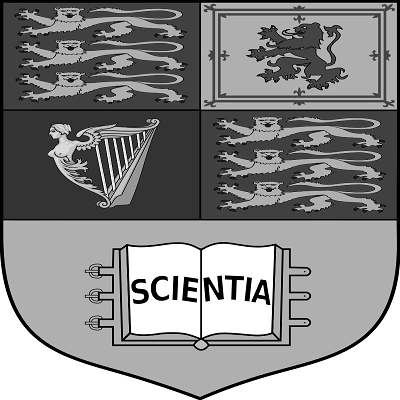

In [10]:
Gray.(channelview(gshield))

**So how can we use a SVD to determine what information in an image is really important?**

The singular values tell us!

If we have matrices $U$, $S$, and $V$ from our image, we can rebuild that image with the matrix product $USV^T$. 

Taking this matrix product is the same as adding together the outer products of each corresponding pair of vectors from $U$ and $V$, scaled by a singular value ($\sigma$) from $S$. In other words, for a (400 x 400) pixel image,

$$A_{image} = USV^T = \sum_{i = 1}^{400} \sigma_i \mathbf{u_i}\mathbf{v_i'} $$

Every outer product $u_i * v_i'$ creates a (400 x 400) matrix. Here we're summing together one hundred (400 x 400) matrices in order to create the original matrix $A_{image}$. The matrices at the beginning of the series -- those that are scaled by **large** singular values -- will be **much** more important in recreating the original matrix $A_{image}$.

This means we can approximate $A_{image}$ as

$$A_{image} \approx \sum_{i = 1}^{n} \sigma_i \mathbf{u_i}\mathbf{v_i'}$$

where $n < 400$.

For example, if we rebuild our image of a shield using only 100 (instead of all 400) singular values, we get

<img src="../assets/shield_4.png" alt="Drawing" style="width: 400px;"/>

Using 50 and then 25 singular values, we get

<img src="../assets/shield_8.png" alt="Drawing" style="width: 400px;"/>
<img src="../assets/shield_16.png" alt="Drawing" style="width: 400px;"/>

#### Exercise

Write a function called `compress_image`. Its input arguments should be an image and the factor by which you want to compress the image. A compressed grayscale image should display when `compress_image` is called.

For example,

```julia
compress_image("../assets/Shield_of_Imperial_College_London.png", 11)
```

will return a compressed image of a grayscale shield built using 36 singular values. (This image has 400 singular values, so use `fld(400, 11)` to determine how many singular values to keep. `fld` performs "floor" division.)

*Hints*: 

* Perform the SVD on the `channelview` of a grayscale image.
* In an empty input cell, execute `?svd` to find a function that wil perform an SVD for you.

In [11]:
function compress_image(img, factor)
    img = channelview(Gray.(img))
    img_svd = svd(img)
    U, S, V = img_svd.U, img_svd.S, img_svd.V
    num_sv = size(S)[1] #gives you the number of singular vectors (400 if you use the Imperial Image we've provided)
    use_sv = fld(num_sv, factor)
    compressed_image = U[:, 1:use_sv] * Diagonal(S[1:use_sv]) * V[:, 1:use_sv]'
    Gray.(compressed_image)
end

compress_image (generic function with 1 method)

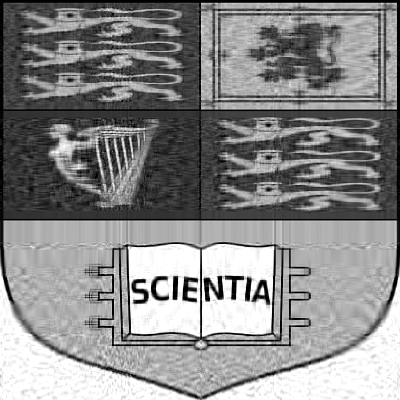

In [13]:
img = load("../assets/Shield_of_Imperial_College_London.png")
compress_image(img, 11)